# Capital Evictions
Impact of development on eviction rates in Washington D.C.


## Table of Contents
1. <a href ='#goal'>Problem Statement</a>
2. <a href='#datasources'>Data Sources</a>
3. <a href='#EDA'>Exploratory Data Analysis</a>
4. <a href='#regression'>Regression</a>
5. <a href='#findings'>Analysis and Findings</a>
6. <a href='#recs'>Recommendations</a>

In [1]:
# Import libraries and set defaults
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

<a id='goal'></a>
## Problem Statement

The goal of this analysis is to gain a better understanding of the relationship between Planned Unit Developments (PUDs), demographic factors, and eviction rates.

<a id='datasources'></a>
## Data Sources

**The Eviction Lab** (https://data-downloads.evictionlab.org/)

A research institution of Princeton University, The Eviction Lab is led by Matthew Desmond with the goal of creating a national resource for tracking evictions and eviction filings.

This project utilizes 2016 evictions data for census block groups within Washington D.C.
 
<br>

**Open Data DC** (https://opendata.dc.gov/datasets/1b3e77aaa6154d1285af639323b0504f_14/data)

A Planned Unit Development refers to a requested exemption from D.C. zoning regulations.  In exchange for the exemption, the developers must offer a community benefit within the local area.  Examples of community benefits include the provision of affordable housing, creation of a park, or contribution to a non-profit. 

This project joins PUD records from Open Data DC with additional research conducted by third-party advocacy group Grassroots D.C. (http://www.grassrootsdc.org/)


In [48]:
# import data
puds = pd.read_csv('data/final_datasets/master_puds_blocks.csv')

<a id='EDA'></a>
### Exploratory Data Analysis

In [3]:
%run python_files/data_viz

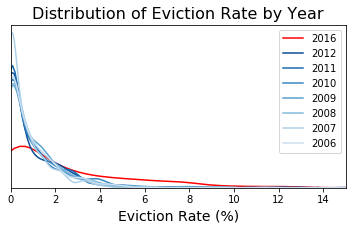

In [4]:
years_dist()

The distribution of eviction rates for 2016 differs significantly from other years in the dataset. However, The Eviction Lab utilizes 2016 as their baseline year for comparison across geographies. Based on their data collection methodology, more records may have been collected for 2016 relative to other years.

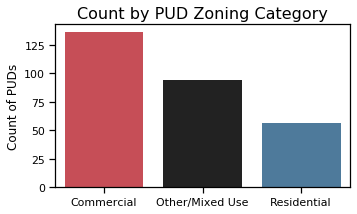

In [5]:
pud_count_by_type(5.3,3)

Majority of PUDs are commercial, followed by mixed use zoning.

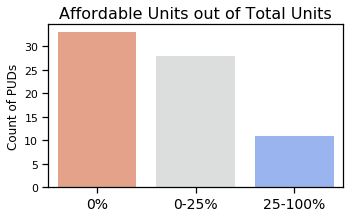

In [6]:
affordable_units_count(5.3,3)

In general, residential PUDs do not include provision of affordable units.

<a id='regression'></a>
# Regression

In [49]:
%run python_files/regression

#### Remove Outliers

In [8]:
puds_to_transform = shrink_data(puds) # limit data to continuous variables
X, y = drop_outliers(puds_to_transform) # drop rows containing a z-score greater than 3
print('Rows in original dataset:', puds_to_transform.shape[0])
print('Rows in updated dataset:', X.shape[0])
print('The target column is', y.columns[0])

Rows in original dataset: 599
Rows in updated dataset: 481
The target column is eviction-rate


#### Multicolinearity Check

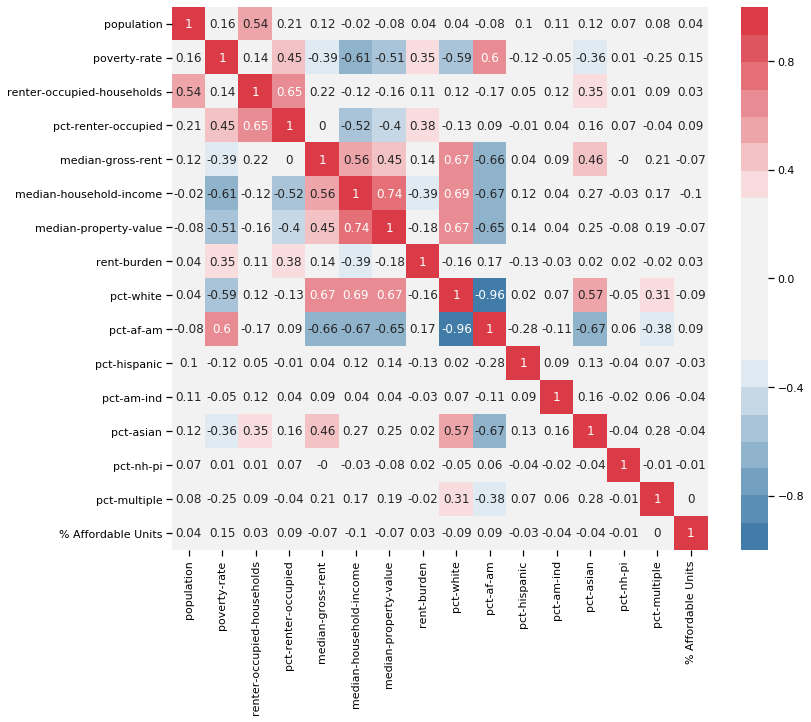

In [9]:
multicolinearity_check(X)

The only variables with a correlation score > 0.75 are 'renter-occupied-households' and 'pct-renter-occupied'. Otherwise, multicolinearity is not a significant issue with this dataset.

In [10]:
X = X.drop('renter-occupied-households',axis=1)

#### Test Train Split

In [14]:
X_train, X_test, y_train, y_test = segment_test_data(X, y, 0.1) # create train-test split

In [15]:
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train.transform(lambda x: np.log(x + 1)))
X_test = ms.transform(X_test.transform(lambda x: np.log(x + 1)))

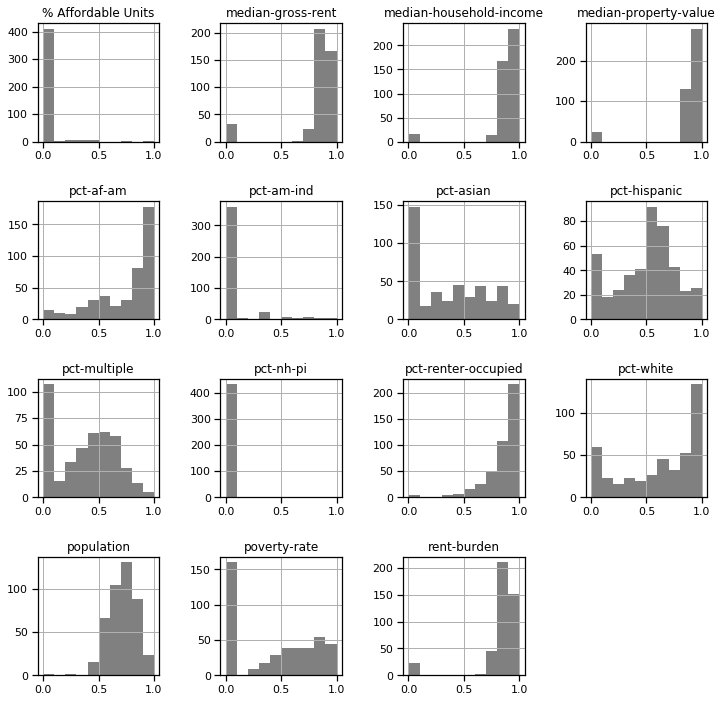

In [16]:
X_labels = [el for el in X.columns]
X, y = transform_arrays_to_df(X_train, y_train, X_labels)
feature_histogram(X) # provide distribution plots of transformed features

### Multiple Linear Regression

In [17]:
# add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [18]:
# multiple linear regression on training data
X_labels = [el for el in X.columns]
model, result = lin_reg(X_train,y_train)
create_summary(result, X_labels)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          eviction-rate   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     40.45
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           1.33e-71
Time:                        14:05:40   Log-Likelihood:                -877.50
No. Observations:                 432   AIC:                             1787.
Df Residuals:                     416   BIC:                             1852.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                   0.7987      1.030      0.776      0.438      -1.226       2.823
population                  1.4889      0.777      1.916      0.056      -0.039       3.017
poverty-rate                1.6803      0.358      4.690      0.000       0.976       2.385
pct-renter-occupied         3.3283      0.813      4.094      0.000       1.730       4.926
median-gross-rent          -1.0098      0.613     -1.648      0.100      -2.214       0.195
median-household-income     0.9114      0.581      1.568      0.118      -0.231       2.054
median-property-value       0.2266      0.490      0.462      0.644      -0.737       1.190
rent-burden                 0.4057      0.742      0.547      0.585      -1.053       1.864
pct-white                  -4.9071      0.513     -9.559      0.000      -5.916      -3.898
pct-af-am                  -0.1155      0.549     -0.210      0.833      -1.194       0.963
pct-hispanic               -0.8496      0.388     -2.188      0.029      -1.613      -0.086
pct-am-ind                  0.0597      0.428      0.140      0.889      -0.781       0.901
pct-asian                  -0.1547      0.414     -0.374      0.709      -0.968       0.659
pct-nh-pi                  -0.1643      1.934     -0.085      0.932      -3.965       3.637
pct-multiple                0.8345      0.378      2.210      0.028       0.092       1.577
% Affordable Units         -0.5410      0.903     -0.599      0.549      -2.316       1.234
==============================================================================
Omnibus:                       42.269   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.202
Skew:                           0.604   Prob(JB):                     4.68e-17
Kurtosis:                       4.649   Cond. No.                         56.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

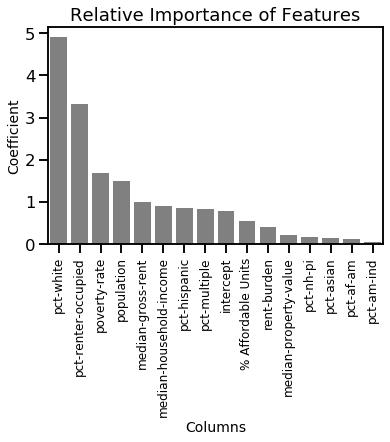

In [19]:
feature_bar_chart(result, X_labels)

Based on coeffients of scaled features, the most important variables for predicting eviction rates at the block group level are “pct-white”, "pct-renter-occupied," “poverty-rate.”

### Residuals Analysis

In [20]:
y_hat_train = result.predict()

In [21]:
X_labels.remove('intercept')

In [53]:
%run python_files/regression

In [56]:
training_table = create_values_table(X, 'pct-white', y, y_hat_train)
training_table.head()

,pct-white,y,y_hat,residual
0,0.694088,4.90,3.633860,1.266140
1,0.498752,3.22,3.955789,-0.735789
2,0.938604,0.00,0.487483,-0.487483
3,0.502467,0.00,2.387805,-2.387805
4,0.919456,1.11,1.212272,-0.102272


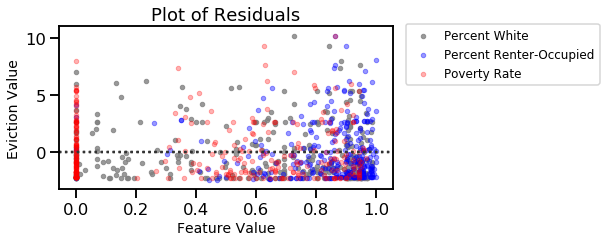

In [23]:
residual_plot(X,y)

In [24]:
residual_checks(X_train,y_train)

Tests of normality of residuals:
   - Jarque-Bera: 75.202
   - p-value: 0.0
   - Skew: 0.604
   - Kurtosis: 4.649


Tests of heteroskedasticty of residuals:
   - Lagrange multiplier statistic: 103.763
   - p-value: 0.0
   - f-value: 8.767
   - f p-value: 0.0


**Intepretation**:
- Small J-B value indicates that errors are normally distributed
- p-value for J-B test is greater than alpha (.05) so fail to reject null hypothesis of normal distribution
- Negative skew indicates that errors are left skewed (i.e. most of the distribution at the right)
- Kurtosis greater than 3 indicates that errors have heavier tails than the normal distribution
- p-value for Lagrange is less than alpha (.05) so reject null hypothesis of homoskedasticity

### Validation

In [27]:
y_hat_test = result.predict(X_test)

In [60]:
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = ['constant']+X_labels
test_table = create_values_table(X_test_df, 'pct-white', y_test, y_hat_test)
test_table.head()

,pct-white,y,y_hat,residual
0,0.844973,2.70,2.113591,0.586409
1,0.877400,1.32,1.076165,0.243835
2,0.889159,0.34,1.118723,-0.778723
3,0.617179,4.74,2.780852,1.959148
4,0.826993,0.54,2.075725,-1.535725


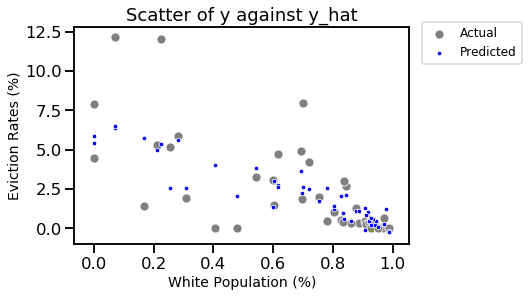

In [76]:
y_vs_y_hat_scatter(test_table['pct-white'], test_table['y'], test_table['y_hat']) 

In [65]:
print('Training MSE:', round(mean_squared_error(y_train, y_hat_train),2))
print('Test MSE:', round(mean_squared_error(y_test, y_hat_test),2))

Training MSE: 3.4
Test MSE: 5.27


<a id='findings'></a>
### Analysis and Findings

1. Eviction disproportionately impacts people of color
2. Percentage of renter occupied households and poverty-rate also have some predictive power for eviction rate
3. The count of PUDs and the provision of afforable housing have no clear impact on eviction rates 

<a id='recs'></a>
### Recommendations

1. Continue analysis at block group level, accounting for the fact that a PUD may be adjacent to one or more block groups
2. Repeat analysis, taking into account PUD status as of 2016 (year of eviction rate data)
3. Evaluate findings across time series data, including development timeline of PUD
4. Repeat analysis with other development vehicles, such as Tax Increment Financing
5. Synthesize findings with additional research about PUD community impact beyond count of affordable units, such as count of family-sized units, project value, etc.
